# CBC News Coronavirus/COVID-19 Articles (NLP)

#### Dataset Description
> <b> It contains the authors, the title, the publish date, the description about the story, the main story, and the url.</b>

## Building  an Abstractive News summarizer with Seq2Seq Model.

In [4]:
#from shutil import copyfile
#copyfile(src = "../input/attention/attention.py", dst = "../working/attention.py")

In [5]:
from attention import AttentionLayer

###### Import the Libraries

In [6]:
import numpy as np
import pandas as pd 
import re
import os
import json
import pickle
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [7]:
#os.listdir('articles/')
os.listdir('cnn_articles/')


['CNN_Articles_clean.csv', 'CNN_Articles_clean2.csv']

In [8]:
#df_news = pd.read_csv('articles/Articles.csv', encoding='latin-1')
df_news = pd.read_csv('cnn_articles/CNN_Articles_clean.csv', encoding='latin-1')


In [9]:
df_news.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-autonomous-truck-spc-intl/index.html,"There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed - CNN","The e-commerce boom has exacerbated a global truck driver shortage, but could autonomous trucks help fix the problem?","world, There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed - CNN","There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed","(CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and s..."
1,2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-exoskeleton-glove-spc-intl/index.html,Bioservo's robotic 'Ironhand' could protect factory workers from injuries - CNN,"Working in a factory can mean doing the same task over and over, which could lead to chronic injury. A battery-powered glove from Swedish company Bioservo could help workers by taking some of the...","world, Bioservo's robotic 'Ironhand' could protect factory workers from injuries - CNN",A robotic 'Ironhand' could protect factory workers from injuries,"(CNN)Working in a factory or warehouse can mean doing the same task over and over, and that repetition can lead to chronic injury. Now, a battery-powered glove could help workers by taking some o..."
2,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robots-hong-kong-warehouse-hnk-spc-intl/index.html,This swarm of robots gets smarter the more it works - CNN,"In a Hong Kong warehouse, a swarm of autonomous robots works 24/7. They're not just working hard, they're working smart; as they operate, they get better at their job.","asia, This swarm of robots gets smarter the more it works - CNN",This swarm of robots gets smarter the more it works,"(CNN)In a Hong Kong warehouse, a swarm of autonomous robots works 24/7. They're not just working hard, they're working smart; as they operate, they get better at their job.The Autonomous Mobile R..."
3,4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics-emerging-markets-russia/index.html,Russia is no longer an option for investors. These emerging markets are - CNN,"For many years, the world's most popular emerging markets have been the so-called BRICS: Brazil, Russia, India, China and South Africa.","investing, Russia is no longer an option for investors. These emerging markets are - CNN",Russia is no longer an option for investors. These emerging markets are,"New York (CNN Business)For many years, the world's most popular emerging markets have been the so-called BRICS: Brazil, Russia, India, China and South Africa.But given that Russia is no longer a m..."
4,7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia-europe-sanctions-energy/index.html,Russian energy investment ban part of new EU sanctions wave - CNN,"The European Union formally approved on Tuesday a new barrage of sanctions against Russia for its invasion of Ukraine, which include bans on investments in the Russian energy sector, luxury goods ...","business, Russian energy investment ban part of new EU sanctions wave - CNN",EU bans investment in Russian energy in new sanctions barrage,"The European Union formally approved on Tuesday a new barrage of sanctions against Russia for its invasion of Ukraine, which include bans on investments in the Russian energy sector, luxury goods ..."


In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            4076 non-null   int64 
 1   Author           4076 non-null   object
 2   Date published   4076 non-null   object
 3   Category         4076 non-null   object
 4   Section          4076 non-null   object
 5   Url              4076 non-null   object
 6   Headline         4076 non-null   object
 7   Description      4076 non-null   object
 8   Keywords         4076 non-null   object
 9   Second headline  4076 non-null   object
 10  Article text     4076 non-null   object
dtypes: int64(1), object(10)
memory usage: 350.4+ KB


In [11]:
df_news.isna().sum()

Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       0
dtype: int64

In [12]:
data = df_news[['Second headline','Article text']]

In [13]:
data.head()

,Second headline,Article text
0,"There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed","(CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and s..."
1,A robotic 'Ironhand' could protect factory workers from injuries,"(CNN)Working in a factory or warehouse can mean doing the same task over and over, and that repetition can lead to chronic injury. Now, a battery-powered glove could help workers by taking some o..."
2,This swarm of robots gets smarter the more it works,"(CNN)In a Hong Kong warehouse, a swarm of autonomous robots works 24/7. They're not just working hard, they're working smart; as they operate, they get better at their job.The Autonomous Mobile R..."
3,Russia is no longer an option for investors. These emerging markets are,"New York (CNN Business)For many years, the world's most popular emerging markets have been the so-called BRICS: Brazil, Russia, India, China and South Africa.But given that Russia is no longer a m..."
4,EU bans investment in Russian energy in new sanctions barrage,"The European Union formally approved on Tuesday a new barrage of sanctions against Russia for its invasion of Ukraine, which include bans on investments in the Russian energy sector, luxury goods ..."


# Information about dataset

Let us look at datatypes and shape of the dataset

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Second headline  4076 non-null   object
 1   Article text     4076 non-null   object
dtypes: object(2)
memory usage: 63.8+ KB


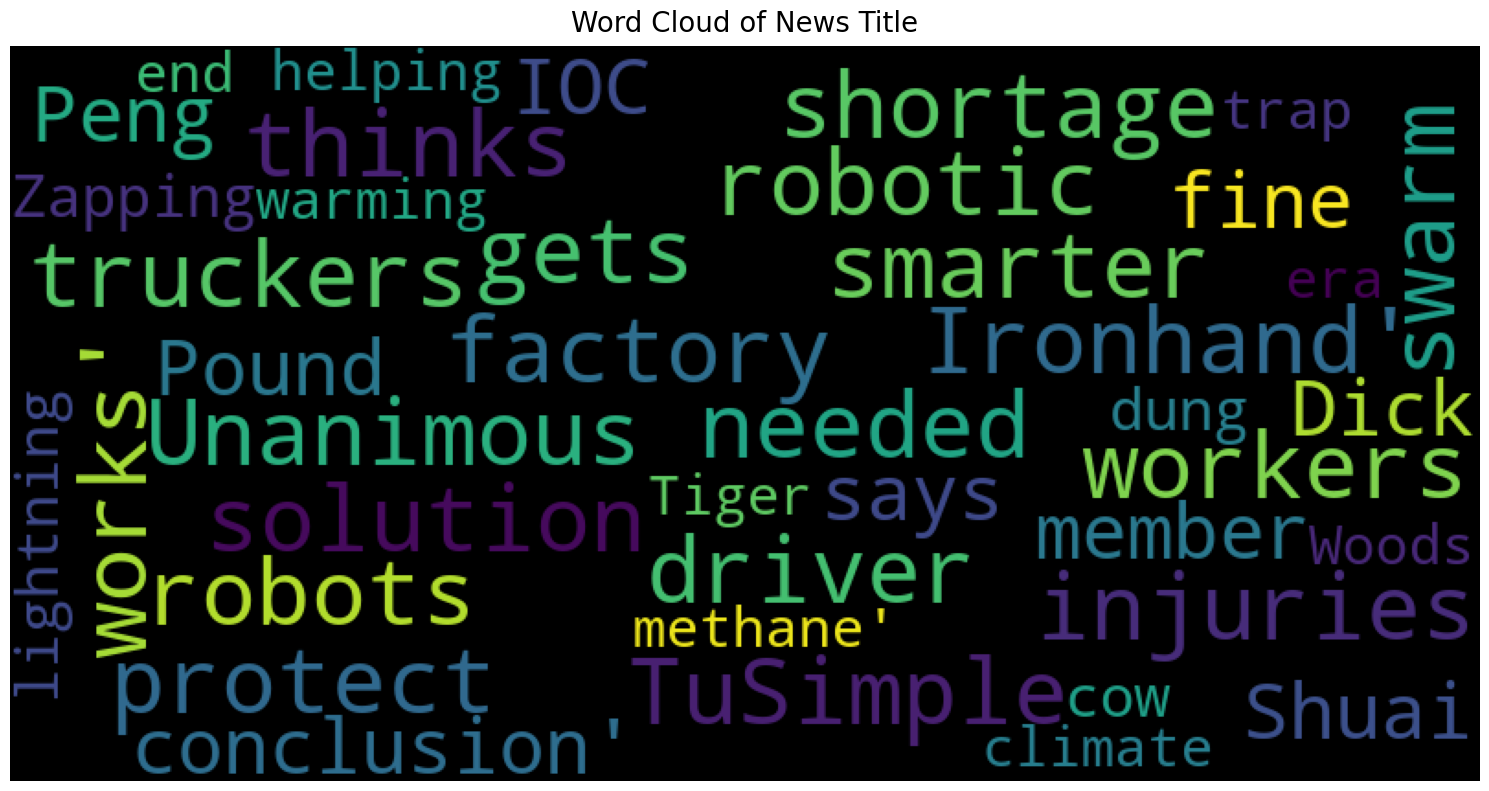

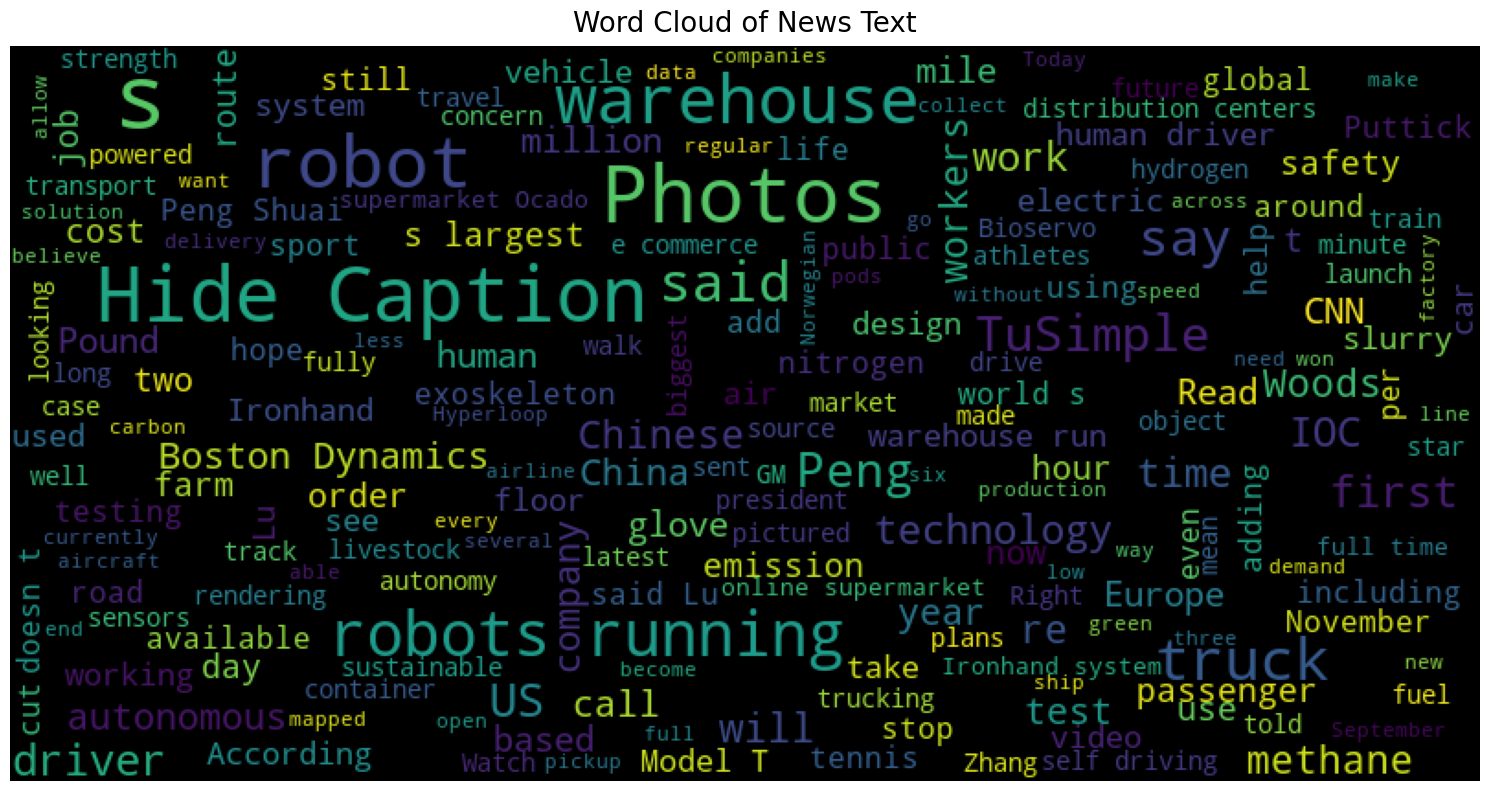

In [15]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=50, figure_size=(15.0,15.0), 
                   title = None, title_size=20, image_color=False,color = None):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data['Second headline'].values, title="Word Cloud of News Title",color = 'black')
plot_wordcloud(data['Article text'].values, title="Word Cloud of News Text",color = 'black')

# Text Data Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move

In [16]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

 - Convert everything to lowercase

 - Remove HTML tags

 - Contraction mapping

 - Remove (‘s)

 - Remove any text inside the parenthesis ( )

 - Eliminate punctuations and special characters

 -  Remove stopwords

 - Remove short words


In [17]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [18]:
#call the function
cleaned_text = []
for t in data['Article text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed text

In [19]:
cleaned_text[:5]  

['right shortage truck drivers us worldwide exacerbated commerce boom brought pandemic one solution problem autonomous trucks several companies race first launch one among san diego based tusimple founded tusimple completed million miles road tests prototype trucks across us china europe although simply commercially available trucks retrofitted technology tusimple deals place two world largest truck manufacturers navistar us traton volkswagen trucking business europe design build fully autonomous models hopes launch photos yara birkeland builders call world first zero emission autonomous cargo ship ship scheduled make first journey two norwegian towns end year click see forms transport set transform future hide caption photos pictured rendering oceanbird wind powered transatlantic car carrier cuts carbon emissions compared standard car carrier hide caption photos maritime ships going green cities around world adopting electric ferries norwegian startup zeabuz hopes self driving electri

In [20]:
#call the function
cleaned_summary = []
for t in data['Second headline']:
    cleaned_summary.append(text_cleaner(t,0))

Let us look at the first 10 preprocessed news titles

In [21]:
cleaned_summary[:10]

['shortage truckers tusimple thinks solution driver needed',
 'robotic ironhand could protect factory workers injuries',
 'swarm robots gets smarter works',
 'russia longer option investors emerging markets',
 'eu bans investment russian energy new sanctions barrage',
 'protester interrupts live russian state news broadcast denounce invasion ukraine',
 'fox news correspondent hospitalized injured ukraine',
 'russia could default debt within days',
 'oil briefly tumbles barrel good news gas prices',
 'russia may found buyer cheap oil india']

In [22]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

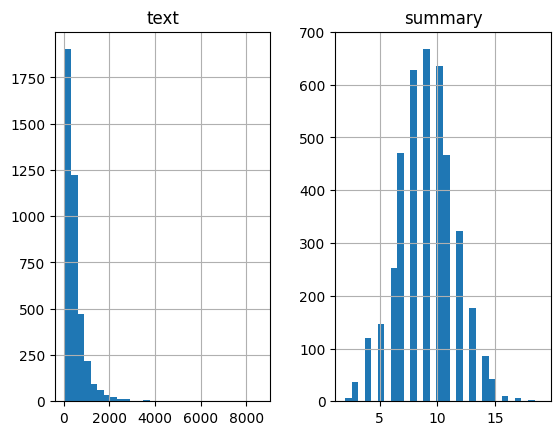

In [23]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Add the **START** and **END** special tokens at the beginning and end of the summary.Add tokens at begining and end of news title  


In [24]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [25]:
max_text_len=300
max_summary_len=15

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [26]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['cleaned_text']),np.array(data['cleaned_summary']),test_size=0.1,random_state=0,shuffle=True) 

In [27]:
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [28]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.732174502642806
Total Coverage of rare words: 3.086383659363881


In [29]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum lengath
x_tr    =   pad_sequences(x_tr_seq,maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq,maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [31]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 85.35668116112352
Total Coverage of rare words: 30.855429680780478


Let us define the tokenizer with top most common words for summary.

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let us check whether word count of start token is equal to length of the training data

In [33]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(3668, 3668)

Delete start and end tokens

In [34]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [35]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## NLP Model Building

In [36]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 100)     2613200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 300, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [37]:
#converts the integer sequence to a one-hot vector using sparse_categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early Stopping - Our model will stop training once the validation loss increases:

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
29/29 [==============================] - 1440s 49s/step - loss: 3.9107 - val_loss: 3.2912
Epoch 2/50
29/29 [==============================] - 1702s 59s/step - loss: 3.2333 - val_loss: 3.0955
Epoch 3/50
29/29 [==============================] - 1890s 65s/step - loss: 3.1413 - val_loss: 2.8501
Epoch 4/50
29/29 [==============================] - 2100s 73s/step - loss: 3.0119 - val_loss: 2.7562
Epoch 5/50
29/29 [==============================] - 2205s 76s/step - loss: 2.9323 - val_loss: 2.7188
Epoch 6/50
29/29 [==============================] - 2302s 80s/step - loss: 2.9002 - val_loss: 2.7014
Epoch 7/50
29/29 [==============================] - 2398s 83s/step - loss: 2.8845 - val_loss: 2.6887
Epoch 8/50
29/29 [==============================] - 2427s 84s/step - loss: 2.8756 - val_loss: 2.6867
Epoch 9/50
29/29 [==============================] - 2461s 85s/step - loss: 2.8705 - val_loss: 2.6838
Epoch 10/50
29/29 [==============================] - 2475s 85s/step - loss: 2.9262 - val_lo

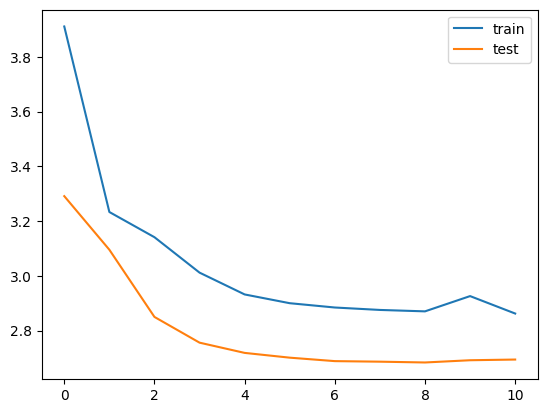

In [40]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [41]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Model Inference

Inferencing Encoder and Decoder for getting predicted summary for title

In [42]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [44]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Result for Inference is shown below with News Text,original summary and predicted summary

In [45]:
for i in range(0,100):
    print("News Text:",seq2text(x_tr[i]))
    print("Original News summary:",seq2summary(y_tr[i]))
    print("Predicted News summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

News Text: iceland looked elected woman majority parliament recount votes sunday showed still men women chamber state broadcaster ruv reported thirty women elected seat parliament saturday election previous vote earlier results recount late sunday shown women elected national electoral commission published results website could immediately reached comment three countries rwanda cuba nicaragua women men parliament mexico united arab emirates split according data inter parliamentary union polling stations reykjavik iceland saturday sept europe sweden finland women representation parliament respectively read north atlantic island people ranked gender equal country world th year running world economic forum report released march opinion polls forecast governing coalition would fall short majority surge support centre right progressive party five seats pushed coalition total count seats according ruv members current government consists prime minister left green movement conservative indepen

### References
 - [comprehensive-guide-text-summarization-using-deep-learning](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)
 - [a-quick-introduction-to-text-summarization-in-machine-learning](https://towardsdatascience.com/a-quick-introduction-to-text-summarization-in-machine-learning-3d27ccf18a9f)
 - [Keras Text Summarizer](https://github.com/chen0040/keras-text-summarization)

<font color='blue'>If you find this kernel awesome and useful please hit upvote 😊 .</font> <br>
<font color='blue'>Cheers!!!! </font>

<img src="https://global.unitednations.entermediadb.net/assets/mediadb/services/module/asset/downloads/preset/Libraries/Graphics+Library/29-01-2020-WHO-CoronaVirus-anim-public-advice.gif/image1170x530cropped.jpg" width="500" height="500" align="center"/>